# Response time minimization problem for East police district

#### Version 4.0

- Goal: Minimize the response time of police vehicles in Oslo police district, Norway.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

#### East police district
East police district is Norway's second largest police district in terms of number of employees, residents and criminal cases, and the country's second smallest in terms of geographical extent. The police district covers 29 municipalities in the counties of Østfold and Akershus - with more than 787,000 inhabitants (3rd quarter 2023 - Source: ssb.no). The district has several large cities, a long coastline - and responsibility for the largest border crossings: Oslo Airport, Svinesund (E6) and Ørje (E18).

In [59]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-17T22:35:40.878179+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

matplotlib: 3.8.3
geopandas : 0.14.3
osmnx     : 1.9.1
pandana   : 0.7
numpy     : 1.26.4
pandas    : 2.2.1



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Network node centrality has been computed and saved locally. Edges contain road speeds and travel times. Road speeds have been increased by 20-40% to simulate police vehicle speeds.

In [61]:
### Load road network from file
East_filepath = "../data/East/EastDriveImputed.graphml" # with travel time attribute
East_graph = ox.load_graphml(East_filepath) # originally in WGS84 (EPSG:4326)

# Extended graph with important roads from neighbouring district
EastExt_filepath = "../data/East/EastExtDriveImputed.graphml" # with travel time attribute
EastExt_graph = ox.load_graphml(EastExt_filepath) # originally in WGS84 (EPSG:4326)

In [62]:
East_graph = ox.projection.project_graph(East_graph, to_crs='EPSG:32633') # project to local UTM zone
EastExt_graph = ox.projection.project_graph(EastExt_graph, to_crs='EPSG:32633') # project to local UTM zone
print(f"Type of East_graph: {type(East_graph)}")
print(f"CRS of East_graph:  {East_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(East_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of East_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of East_graph:  EPSG:32633


Convert MultiDiGraph to node and edge GeoDataFrames.

In [63]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(East_graph, nodes=True, edges=True)
nodes_ext, edges_ext = ox.graph_to_gdfs(EastExt_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes_ext)}")

# nodes.head()
edges_ext.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid  \
u         v          key                                      
265629056 8595477415 0    [629271201, 120466454, 926242999]   
          8595512022 0               [926242773, 110781343]   

                                                 name       highway  oneway  \
u         v          key                                                      
265629056 8595477415 0    [Storesandveien, Vadholmen]  unclassified   False   
          8595512022 0                      Storveien       primary   False   

                         reversed   length  \
u         v          key                     
265629056 8595477415 0       True 1061.374   
          8595512022 0      False  435.557   

                                                                   geometry  \
u         v          key                                                      
265629056 8595477415 0    LINESTRING (271942.408 6550299.054, 271939.667...   
          8595512022 0    LINESTRING (271942.408 6550299.054, 271945.319...   

                          speed_kph  travel_time  ref  maxspeed bridge  \
u         v          key                                                 
265629056 8595477415 0       39.100       97.700  NaN       NaN    NaN   
          8595512022 0       50.000       31.400  108  [40, 60]    NaN   

                         junction lanes tunnel width access area est_width  \
u         v          key                                                     
265629056 8595477415 0        NaN   NaN    NaN   NaN    NaN  NaN       NaN   
          8595512022 0        NaN   NaN    NaN   NaN    NaN  NaN       NaN   

                         service  
u         v          key          
265629056 8595477415 0       NaN  
          8595512022 0       NaN

Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [64]:
# increase speed of edges
edges_ext_increased = utilityModule.increase_edge_speeds(edges_ext)
edges_ext_increased.head(2) # verify increased edge speeds and shorter travel times

osmid  \
u         v          key                                      
265629056 8595477415 0    [629271201, 120466454, 926242999]   
          8595512022 0               [926242773, 110781343]   

                                                 name       highway  oneway  \
u         v          key                                                      
265629056 8595477415 0    [Storesandveien, Vadholmen]  unclassified   False   
          8595512022 0                      Storveien       primary   False   

                         reversed   length  \
u         v          key                     
265629056 8595477415 0       True 1061.374   
          8595512022 0      False  435.557   

                                                                   geometry  \
u         v          key                                                      
265629056 8595477415 0    LINESTRING (271942.408 6550299.054, 271939.667...   
          8595512022 0    LINESTRING (271942.408 6550299.054, 271945.319...   

                          speed_kph  travel_time  ref  maxspeed bridge  \
u         v          key                                                 
265629056 8595477415 0       47.103       81.120  NaN       NaN    NaN   
          8595512022 0       61.427       25.526  108  [40, 60]    NaN   

                         junction lanes tunnel width access area est_width  \
u         v          key                                                     
265629056 8595477415 0        NaN   NaN    NaN   NaN    NaN  NaN       NaN   
          8595512022 0        NaN   NaN    NaN   NaN    NaN  NaN       NaN   

                         service  
u         v          key          
265629056 8595477415 0       NaN  
          8595512022 0       NaN

In [65]:
# recombining nodes and increased edges to MultiDiGraph format
EastExt_graph_increased = ox.graph_from_gdfs(nodes_ext, edges_ext_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.
- Correct extent: Akershus and Østfold counties minus Asker, Bærum, Jevnaker and Lunner.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [66]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
East_polygon_path = "../data/East/EastCombinedPolygon.geojson"
population_path = "../data/East/EastPopulation.geojson"
East_polygon_gdf = gpd.read_file(East_polygon_path)
population_gdf = gpd.read_file(population_path)
East_polygon_gdf = East_polygon_gdf.to_crs(East_graph.graph['crs']) # convert to same CRS as the road network
population_gdf = population_gdf.to_crs(East_graph.graph['crs']) # convert to same CRS as the road network
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  22735006545750           4   
1  22737506546000           2   

                                            geometry  
0  POLYGON ((273500.000 6545750.000, 273500.000 6...  
1  POLYGON ((273750.000 6546000.000, 273750.000 6...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [67]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1000, max_range=1100) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=5300, max_range=5400) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 6):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 5352. Target range [5300, 5400], using population multiplier: 0.008347656250000002


id  population  \
17847  22735006649250        1697   
6398   22740006649000        1147   
17843  22737506649000        1186   

                                                geometry  num_points  
17847  POLYGON ((273500.000 6649250.000, 273500.000 6...          14  
6398   POLYGON ((274000.000 6649000.000, 274000.000 6...          10  
17843  POLYGON ((273750.000 6649000.000, 273750.000 6...          10

In [68]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

geometry
0  POINT (272291.549 6549515.844)
1  POINT (272464.357 6549879.751)
2  POINT (272770.580 6549829.909)

In [69]:
# create polygons around high event density areas
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, density_threshold=1.0e-10, simplification_tolerance=5.0, plot_results=False)

Density: Min: 5.155e-25 | Median: 4.154e-11 | Mean: 9.318e-11 | Max: 8.932e-10


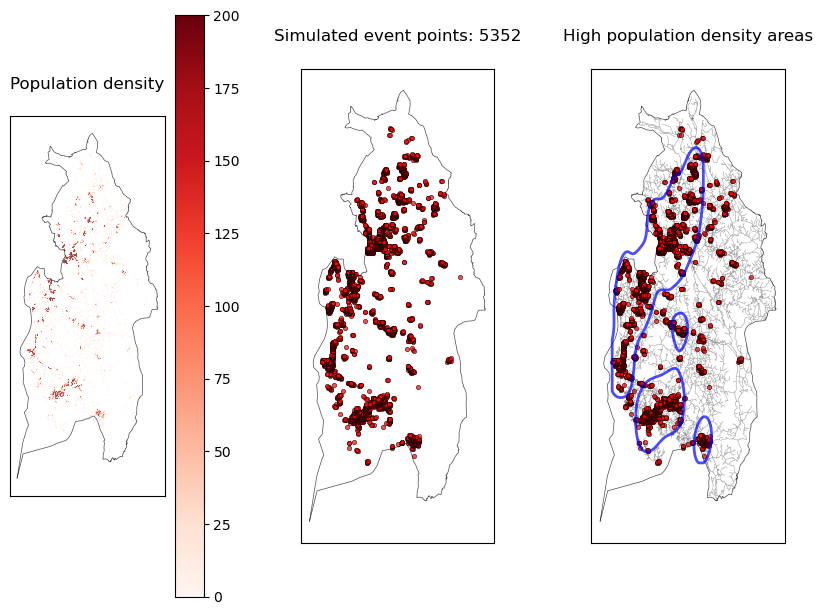

In [70]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(East_polygon_gdf, population_gdf, event_points_gdf, high_pop_density_area, edges, figsize=(10, 10))

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [71]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/East/EastExtNodeCentrality.csv")

# Now use the merge function. Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, you can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count    lon    lat highway  ref  \
osmid                                                                        
265629056  6550299.054 271942.408             3 11.025 59.031     NaN  NaN   
8595477415 6549913.134 271187.495             1 11.013 59.027     NaN  NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
265629056   POINT (271942.408 6550299.054)                 0.000   
8595477415  POINT (271187.495 6549913.134)                 0.000   

            betweenness_centrality  
osmid                               
265629056              8986372.000  
8595477415                   0.000

### 2.2 Sample candidate points and filter out best candidate points

In [72]:
# random nodes from the graph
SEED = 3
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 47981, nr of police car nodes: 100


y          x  street_count    lon    lat highway  ref  \
osmid                                                                       
247945379 6666557.437 287658.954             3 11.182 60.081     NaN  NaN   
469973688 6577514.613 274028.557             3 11.034 59.276     NaN  NaN   

                                 geometry  closeness_centrality  \
osmid                                                             
247945379  POINT (287658.954 6666557.437)                 0.000   
469973688  POINT (274028.557 6577514.613)                 0.000   

           betweenness_centrality  
osmid                              
247945379             3586676.000  
469973688             1902940.000

Input nr of car nodes: 100
Remaining nr of car nodes: 80, after discarding the 20 (20%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


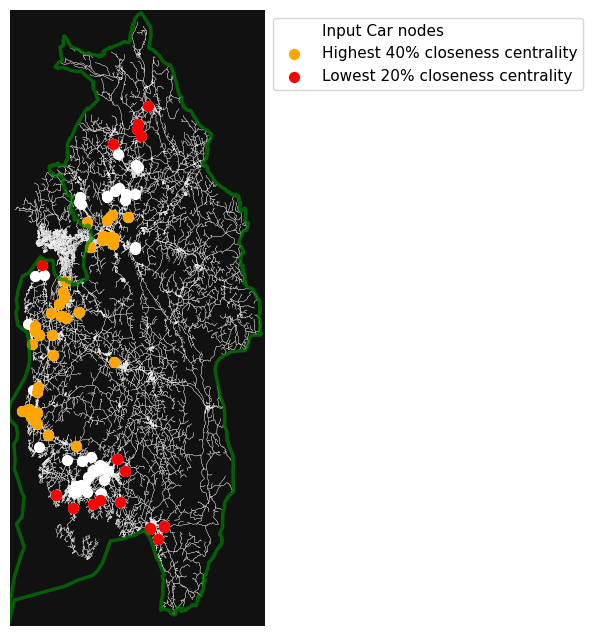

In [73]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=East_polygon_gdf, 
            top_percent=0.4, bottom_percent=0.20, input_graph=EastExt_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 80
Remaining nr of car nodes: 52, after discarding the 28 (35%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


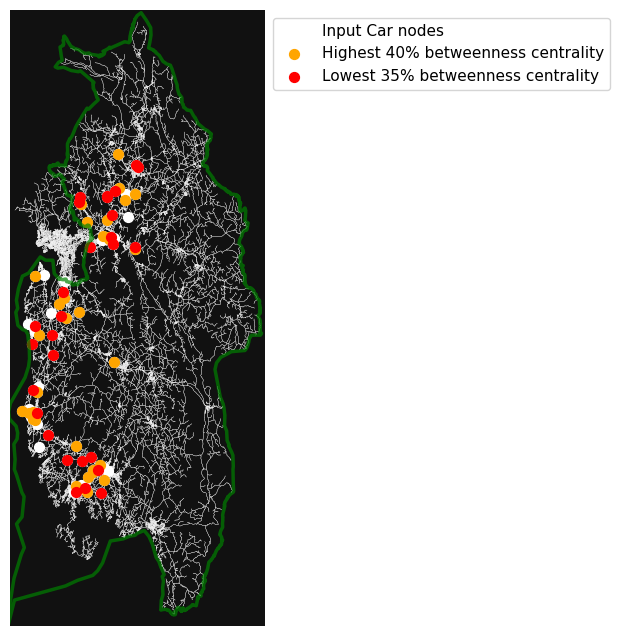

In [74]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=East_polygon_gdf,
        top_percent=0.4, bottom_percent=0.35, input_graph=EastExt_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 52
Remaining nr of car nodes: 20, after removing the 32 nodes that are within 5000 m of each other



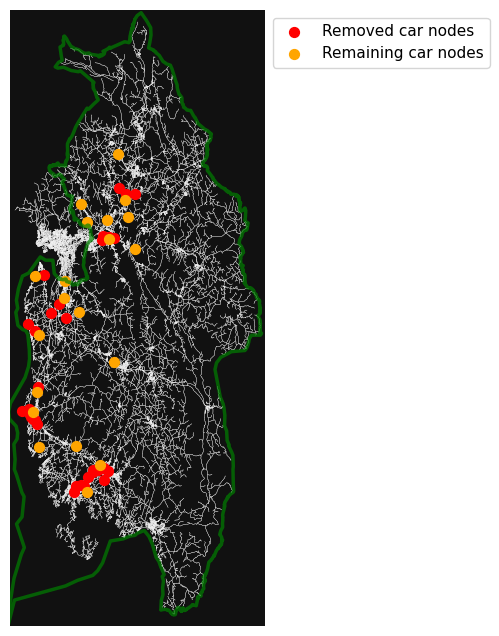

In [75]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=East_polygon_gdf,
         min_distance=5000, input_graph=EastExt_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [76]:
# reset index so our origins and destinations are not in index
edges_ext = edges_ext_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed
# nodes = nodes.reset_index()

# create network with pandana
East_extended_network_pdna = pdna.Network(node_x=nodes_ext['x'], node_y=nodes_ext['y'], edge_from=edges_ext['u'], edge_to=edges_ext['v'], 
                                      edge_weights=edges_ext[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of East_extended_network_pdna: {type(East_extended_network_pdna)}")
print(f"Network nodes:")
East_extended_network_pdna.nodes_df.head(2)

type of East_extended_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                            
265629056  271942.408 6550299.054
8595477415 271187.495 6549913.134

In [77]:
print(f"Network edges: ")
East_extended_network_pdna.edges_df.head(2)

Network edges: 


from          to   length  travel_time
0  265629056  8595477415 1061.374       81.120
1  265629056  8595512022  435.557       25.526

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [78]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = East_extended_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry  nearest_node          x           y
0  POINT (272291.549 6549515.844)    8595512250 272347.524 6549507.607
1  POINT (272464.357 6549879.751)   10314220723 272426.708 6549891.510

In [79]:
# Get list of nearest node ids for event locations
event_nodes_pdna = East_extended_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
print("Length of event_nodes_pdna: ", len(event_nodes_pdna))
print("Number of unique nodes: ", len(np.unique(event_nodes_pdna)))
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = East_extended_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

Length of event_nodes_pdna:  5325
Number of unique nodes:  4791


array([2000313169, 2509795414,   29783958, 1107719023, 3832602475],
      dtype=int64)

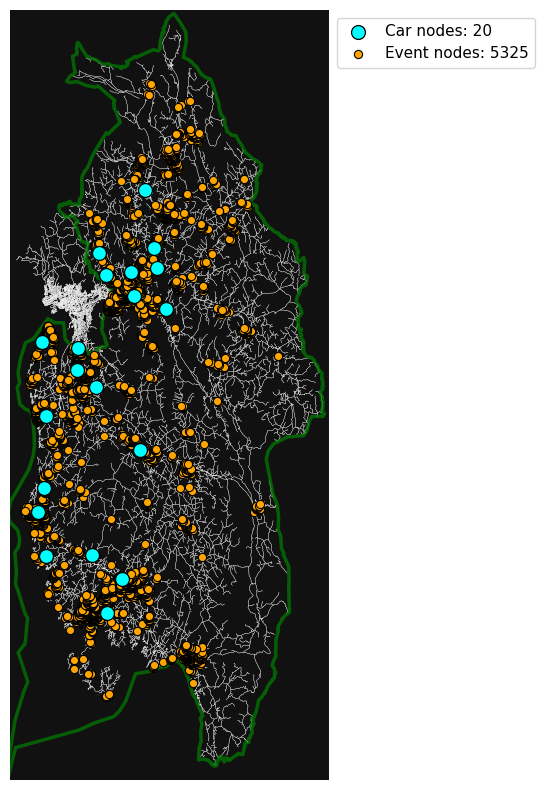

In [80]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(EastExt_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
East_polygon_gdf.boundary.plot(ax=ax, color='green', linewidth=2.5, alpha=0.7)
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [81]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [82]:
%%time
# travel time between each possible pair of car-event combination
distances = East_extended_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = East_extended_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

20 origins x 5325 destinations = 106500 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [131139.851, 130754.922, 131386.451, 130844.826, 131437.507]
5 first origin-destination travel times [sec]: [4550.101, 4513.63, 4557.697, 4520.709, 4584.991]
CPU times: total: 7.58 s
Wall time: 883 ms


In [83]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times) / 60 # in minutes
travel_times_df.describe().T

count   mean    std   min    25%    50%    75%    max
0 106500.000 33.105 17.701 0.000 19.206 31.734 45.807 89.807

In [84]:
# Restructure the distances and travel times arrays into a DataFrame (Cost Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes_ext[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes_ext[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time   carNodeID  eventNodeID          x           y
0 131139.851     4550.101  2000313169   8595512250 272347.524 6549507.607
1 130754.922     4513.630  2000313169  10314220723 272426.708 6549891.510

In [85]:
# Save cEast matrix to CSV
CostMatrix.to_csv("../data/East/EastExtCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [86]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time   carNodeID    eventNodeID
0     4550.101  2000313169   8595512250_1
1     4513.630  2000313169  10314220723_1

In [87]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.30

# Constants
NR_OF_CARS = 4
margin = len(event_nodes_pdna) * 0.04 # 4% of all events
CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 1544 events per car
Filtering out 30% highest travel times - keeping only travel times <= 2580 sec, or 43.0 min
Original nr of pairs: 106500 | Filtered nr of pairs: 74551
Original max travel time: 5388.423 | Filtered max travel time: 2579.622


### 5.2 Setup LP problem

In [88]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 20
Number of events: 5325


Number of decision variables: 74571
Number of constraints: 79897
Number of non-zero coefficients: 74571
Number of non-zero coefficients in the objective function: 74549
CPU times: total: 2.75 s
Wall time: 3.8 s


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).


In [89]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 30%)
PULP_CBC_CMD with LP relaxation found 2/4 locations in 57.70 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 378.37 seconds: [2000313169 2509795414 8126603530   31317435]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 3476843.4270 seconds, or 57947.39 minutes, or 965.79 hours
CPU times: total: 9.45 s
Wall time: 7min 22s


### 5.6 Extract results for inspection

In [90]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
# print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/East/EastCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Car 2000313169 is assigned 1415/1544 events
Car 2509795414 is assigned 1543/1544 events
Car 8126603530 is assigned 1533/1544 events
Car 31317435 is assigned 834/1544 events
Summing the events for each car gives 5325 events, which should equal the total number of unique events: 5325


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 20 | Optimal locations in solution: 4
- Events: 5325 | Max event capacity per police car: 1544

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 3476843 sec | 57947.4 min | 965.79 hours

Car id: 2000313169 handles 1415 events | Capacity: 91.65% | Total response time: 10235.85 min | Median: 4.97 min | Avg: 7.23 min
Car id: 2509795414 handles 1543 events | Capacity: 99.94% | Total response time: 16918.22 min | Median: 11.17 min | Avg: 10.96 min
Car id: 8126603530 handles 1533 events | Capacity: 99.29% | Total response time: 21506.57 min | Median: 13.35 min | Avg: 14.03 min
Car id: 31317435 handles 834 events | Capacity: 54.02% | Total response time: 9286.74 min | Median: 10.52 min | Avg: 11.14 min


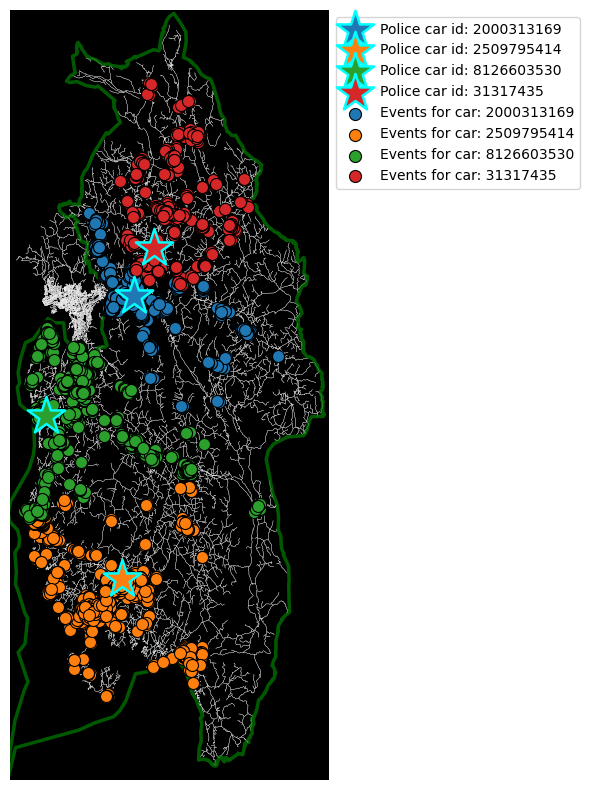

CPU times: total: 8.08 s
Wall time: 9.26 s


In [91]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(EastExt_graph, East_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [92]:
# Define how many trip times to visualize
TRIP_TIMES = [10, 25, 40]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [93]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(EastExt_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=250, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 2min 52s
Wall time: 3min


Isochrone polygons for the travel times: [10, 25, 40] minutes


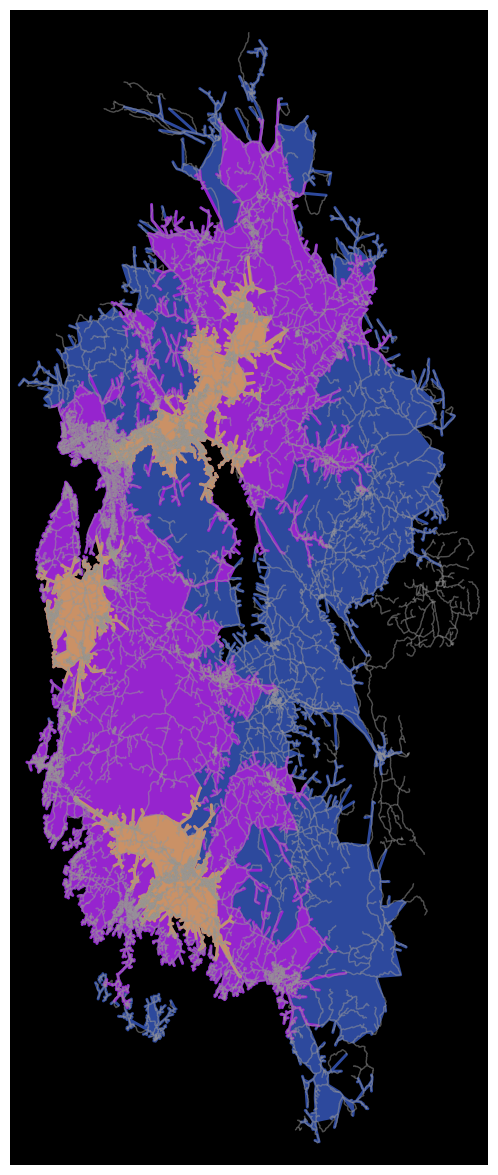

In [94]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(EastExt_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [95]:
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(EastExt_graph_increased, TRIP_TIMES, merged_isochrones, East_polygon_gdf, background_poly=True)
isochrone_map